Epoch [1/50], Loss: 1.1177978515625, Attention Loss: 0.21701093018054962
Test Accuracy: 0.635593220338983
Epoch [2/50], Loss: 0.7568780680497488, Attention Loss: 0.19393764436244965
Test Accuracy: 0.6271186440677966
Epoch [3/50], Loss: 0.6033868630727132, Attention Loss: 0.15737302601337433
Test Accuracy: 0.6991525423728814
Epoch [4/50], Loss: 0.41541732251644137, Attention Loss: 0.13302381336688995
Test Accuracy: 0.8050847457627118
Epoch [5/50], Loss: 0.22191560367743174, Attention Loss: 0.12786723673343658
Test Accuracy: 0.8050847457627118
Epoch [6/50], Loss: 0.1193805243819952, Attention Loss: 0.11234994977712631
Test Accuracy: 0.8516949152542372
Epoch [7/50], Loss: 0.15430651394029457, Attention Loss: 0.11488068103790283
Test Accuracy: 0.7796610169491526
Epoch [8/50], Loss: 0.17924813007315, Attention Loss: 0.10702632367610931
Test Accuracy: 0.8135593220338984
Epoch [9/50], Loss: 0.1472649370630582, Attention Loss: 0.10258277505636215
Test Accuracy: 0.8050847457627118
Epoch [10/50]

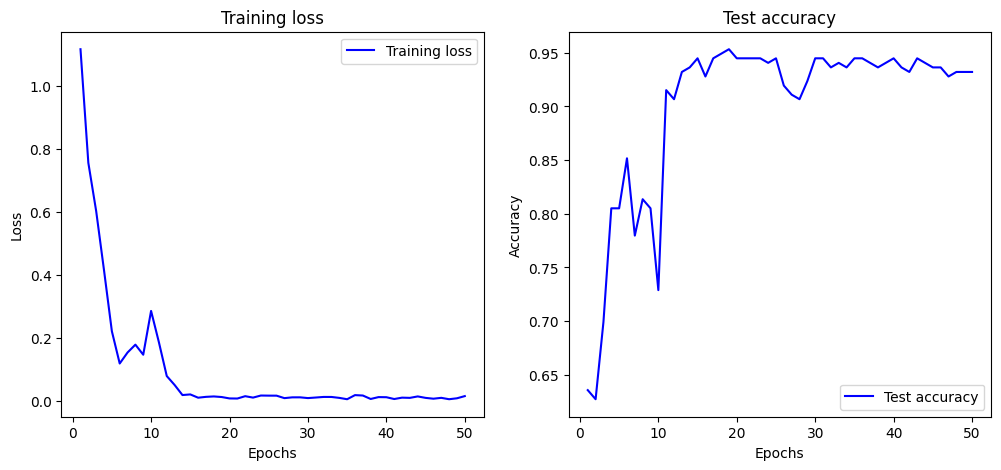

<Figure size 1000x900 with 0 Axes>

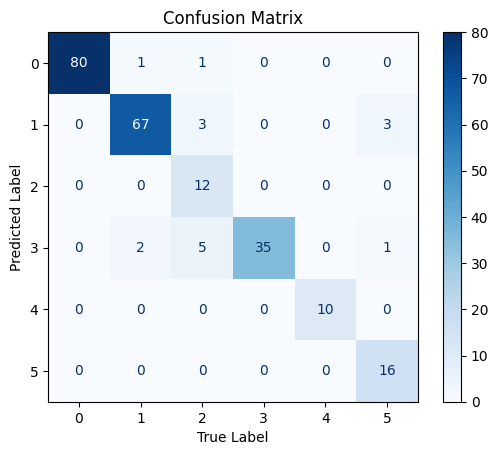

Class 0 accuracy: 0.9756
Class 1 accuracy: 0.9589
Class 2 accuracy: 1.7500
Class 3 accuracy: 0.8140
Class 4 accuracy: 1.0000
Class 5 accuracy: 1.2500


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms
import os
from PIL import Image
import datetime
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import xml.etree.ElementTree as ET
import torchvision.models as models
import matplotlib.pyplot as plt
from tqdm import tqdm
# Load the pre-trained VGG16 model

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
class vgg16_base(nn.Module):
    def __init__(self):
        super(vgg16_, self).__init__()
        vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        self.features = vgg.features
        self.avgpool = vgg.avgpool
        set_parameter_requires_grad(self.features, True)
        self.classifier=nn.Sequential(
            nn.Linear(512*7*7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 6)
        )
    def forward(self, x):
        x = self.features(x) 
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
class vgg16_(nn.Module):
    def __init__(self, num_classes=6):
        super(vgg16_, self).__init__()
        # 原始VGG16特征提取
        vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        self.features = vgg.features
        self.avgpool = vgg.avgpool
        # set_parameter_requires_grad(self.features, True)
        self.num_classes = num_classes
        # 分类器
        self.classifier = nn.Sequential(
            nn.Linear(512*7*7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )
        self.feature_maps = None
        self.gradients = None

        self.features[-1].register_forward_hook(self.save_feature_maps)
        self.features[-1].register_full_backward_hook(self.save_gradients)
    def save_feature_maps(self, module, input, output):
        self.feature_maps = output
    def save_gradients(self, module, input, grad_output):
        self.gradients =grad_output[0]

    def forward(self, x, mask=None,annotation=None):
        features = self.features(x)
        x = self.avgpool(features)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        attention_loss = 0.0
        if mask is not None and torch.sum(mask) > 0:
            with torch.enable_grad():
                # 创建独热向量
                # Initialize attention loss
                attention_loss = 0.0
                one_hot = torch.zeros_like(x)
                one_hot.scatter_(1, annotation.view(-1, 1), 1.0)
                
                # Backpropagate to get gradients
                gradients = torch.autograd.grad(outputs=x, inputs=features, grad_outputs=one_hot, retain_graph=True, create_graph=True)[0]
                # Calculate heatmap
                pooled_gradients = torch.mean(gradients, dim=[2, 3], keepdim=True)
                heatmap = features * pooled_gradients
                heatmap = torch.sum(heatmap, dim=1, keepdim=True)
                heatmap = torch.relu(heatmap)
                
                # Apply ReLU to highlight positive contributions
                
                # Normalize heatmap to 0-1 range
                B, C, H, W = heatmap.size()
                heatmap_flat = heatmap.view(B, C, -1)
                heatmap_max, _ = torch.max(heatmap_flat, dim=2, keepdim=True)
                heatmap_min, _ = torch.min(heatmap_flat, dim=2, keepdim=True)
                heatmap_max = heatmap_max.unsqueeze(-1)
                heatmap_min = heatmap_min.unsqueeze(-1)
                
                # Avoid division by zero
                epsilon = 1e-7
                normalized_heatmap = (heatmap - heatmap_min) / (heatmap_max - heatmap_min + epsilon)
                
                # Resize mask to match heatmap size
                # if annotation==i:
                mask_resized = F.interpolate(mask, size=(H, W), mode='bilinear', align_corners=False)
                # else:
                #     mask_resized = torch.zeros_like(normalized_heatmap)
                # Calculate heatmap loss (MSE loss)
                attention_loss = F.mse_loss(normalized_heatmap, mask_resized)
        return x, attention_loss
class tablet_dataset(Dataset):
    def __init__(self, image_dir, annotation_dir, image_transform=None):
        super().__init__()
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.image_filenames = [f for f in os.listdir(image_dir) if f.endswith('.bmp') and not f.endswith('_t.bmp')]
        self.image_transform = image_transform
    def __len__(self):
        return len(self.image_filenames)
    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        annotation = 0
        mask_name = os.path.splitext(img_name)[0] + '_t.bmp'
        mask_path = os.path.join(self.annotation_dir, mask_name)
        xml_filename = os.path.splitext(img_name)[0] + '.xml'
        xml_path = os.path.join(self.annotation_dir, xml_filename)
        if os.path.exists(xml_path):
            tree = ET.parse(xml_path)
            root = tree.getroot()
            annotation = int(root.find(".//flags").text)
            if annotation==6:
                annotation=1
            elif annotation==7:
                annotation=6
            elif annotation==8:
                annotation=4
            if annotation>1:
                annotation-=1
        mask = None
        if os.path.exists(mask_path) and annotation!=0:
            mask = Image.open(mask_path).convert('L')
            mask = mask.resize((160, 160))
            mask = transforms.ToTensor()(mask)
        else:
            mask = torch.zeros((1, 160, 160))
        if self.image_transform:
            image = self.image_transform(image)
        return image, annotation, mask
# Define the image transformations
image_transform = transforms.Compose([
    transforms.Resize((160,160)),
    # transforms.ColorJitter(contrast=2.0),  # Increase contrast
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



# Modify the VGG16 model for binary classification
vgg16 = vgg16_().to('cuda')
# Apply Xavier initialization to the classifier layers
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

vgg16.classifier.apply(initialize_weights)
# vgg16.load_state_dict(torch.load('vgg16_mask_very_good.pth'))
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.parameters(), lr=0.0001)

# Initialize lists to store loss and accuracy
train_losses = []
test_accuracies = []

# Function to plot loss and accuracy
def plot_metrics(train_losses, test_accuracies):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.title('Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot test accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, test_accuracies, 'b', label='Test accuracy')
    plt.title('Test accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
# Training loop
if __name__ == '__main__':
    # Create the dataset and dataloader
    dataset = tablet_dataset(image_dir='20241108 with rgb', annotation_dir='20241108 with rgb', image_transform=image_transform)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True,num_workers=8)
    testdataset = tablet_dataset(image_dir='train', annotation_dir='train', image_transform=image_transform)
    testloader = DataLoader(testdataset, batch_size=32, shuffle=True,num_workers=8)
    num_epochs = 50
    for epoch in range(num_epochs):
        vgg16.train()
        running_loss = 0.0
        if epoch==20:
            optimizer = optim.Adam(vgg16.parameters(), lr=0.00001)
        for images, labels, masks in dataloader:
            
            images = images.to('cuda')
            labels = labels.to('cuda')
            masks = masks.to('cuda')
            optimizer.zero_grad()
            # if masks is not None:
            outputs,attention_loss = vgg16(images, masks, labels)
            loss = criterion(outputs, labels)+0*attention_loss
            loss.backward()
            optimizer.step()
            
            running_loss += criterion(outputs, labels).item()
        train_losses.append(running_loss/len(dataloader))
        vgg16.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels, _ in testloader:
                images = images.to('cuda')
                labels = labels.to('cuda')
                outputs,_ = vgg16(images)
                predicted = torch.argmax(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total
        test_accuracies.append(accuracy)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader)}, Attention Loss: {attention_loss.item()}')
        print(f'Test Accuracy: {accuracy}')
        if accuracy>.92:
            optimizer = optim.Adam(vgg16.parameters(), lr=0.00001)
        # if accuracy>.95:
        #     break
        # Track and save the best model based on accuracy
        if not hasattr(vgg16, 'best_accuracy') or accuracy > vgg16.best_accuracy:
            vgg16.best_accuracy = accuracy
            timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
            global best_model_path
            best_model_path = f'vgg16_best_model_{accuracy:.4f}_{timestamp}.pth'
            # torch.save(vgg16.state_dict(), best_model_path)
            # print(f'Saved new best model with accuracy: {accuracy:.4f}')
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    # torch.save(vgg16.state_dict(), f'vgg16_model_{num_epochs}epoch_{timestamp}.pth')
    plot_metrics(train_losses, test_accuracies)
    # Add code for confusion matrix evaluation
    # vgg16.load_state_dict(torch.load(best_model_path))
    # Set model to evaluation mode
    vgg16.eval()

    # Initialize lists to store predictions and true labels
    all_predictions = []
    all_labels = []

    # Collect predictions and labels from the test set
    with torch.no_grad():
        for images, labels, _ in testloader:
            images = images.to('cuda')
            labels = labels.to('cuda')
            
            outputs,_ = vgg16(images)
            _, predictions = torch.max(outputs, 1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert lists to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)

    # Generate confusion matrix with axes swapped (predictions on y-axis, true labels on x-axis)
    cm = confusion_matrix(all_labels, all_predictions).T
    num_classes = len(np.unique(np.concatenate([all_labels, all_predictions])))

    # Display the confusion matrix
    plt.figure(figsize=(10, 9))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                 display_labels=list(range(num_classes)))
    disp.plot(cmap=plt.cm.Blues)
    plt.xlabel('True Label')
    plt.ylabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix_mask4.png')
    plt.show()
    # Calculate per-class accuracy (adjusted for transposed matrix)
    per_class_accuracy = cm.sum(axis=0) / cm.sum(axis=1)
    for i, accuracy in enumerate(per_class_accuracy):
        print(f'Class {i} accuracy: {accuracy:.4f}')
    # Save the model
    torch.save(vgg16.state_dict(), 'vgg16_mask_trained_model1.pth')

Epoch [1/50], Loss: 1.1148712555567424
Test Accuracy: 0.6440677966101694
Epoch [2/50], Loss: 0.692144513130188
Test Accuracy: 0.7288135593220338
Epoch [3/50], Loss: 0.4491599808136622
Test Accuracy: 0.7754237288135594
Epoch [4/50], Loss: 0.30835648874441784
Test Accuracy: 0.7203389830508474
Epoch [5/50], Loss: 0.18396319368233283
Test Accuracy: 0.7838983050847458
Epoch [6/50], Loss: 0.1047818385840704
Test Accuracy: 0.8601694915254238
Epoch [7/50], Loss: 0.07013851025452217
Test Accuracy: 0.8983050847457628
Epoch [8/50], Loss: 0.1349122711767753
Test Accuracy: 0.8940677966101694
Epoch [9/50], Loss: 0.11123815796648463
Test Accuracy: 0.826271186440678
Epoch [10/50], Loss: 0.22277279881139597
Test Accuracy: 0.864406779661017
Epoch [11/50], Loss: 0.14439445104605209
Test Accuracy: 0.9533898305084746
Epoch [12/50], Loss: 0.044118039620419346
Test Accuracy: 0.940677966101695
Epoch [13/50], Loss: 0.035667797457426785
Test Accuracy: 0.9576271186440678
Epoch [14/50], Loss: 0.028278096761156727

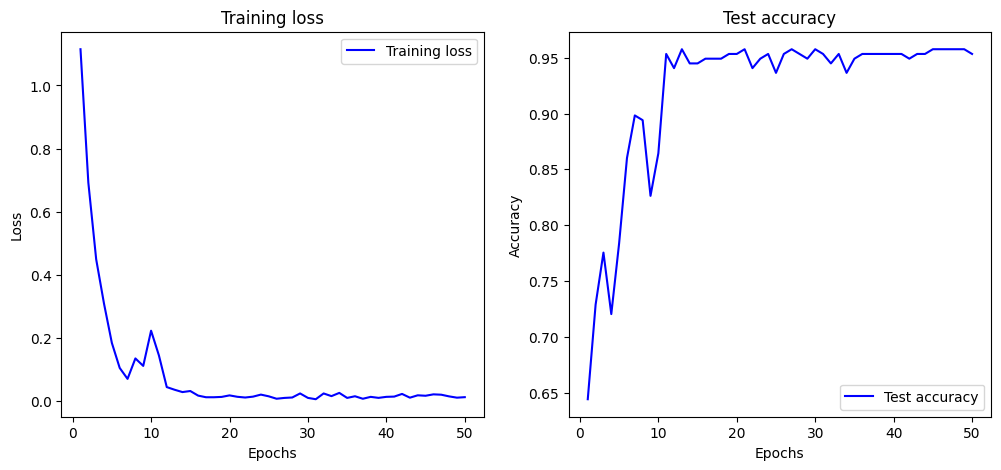

<Figure size 1000x900 with 0 Axes>

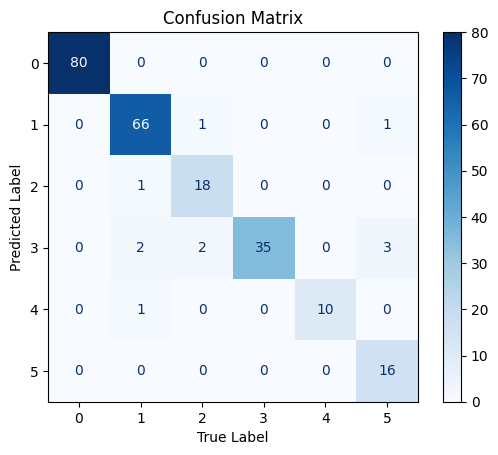

Class 0 accuracy: 1.0000
Class 1 accuracy: 1.0294
Class 2 accuracy: 1.1053
Class 3 accuracy: 0.8333
Class 4 accuracy: 0.9091
Class 5 accuracy: 1.2500


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms
import os
from PIL import Image
import datetime
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import xml.etree.ElementTree as ET
import torchvision.models as models
import matplotlib.pyplot as plt
from tqdm import tqdm
# Load the pre-trained VGG16 model

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
class vgg16_(nn.Module):
    def __init__(self):
        super(vgg16_, self).__init__()
        vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        self.features = vgg.features
        self.avgpool = vgg.avgpool
        set_parameter_requires_grad(self.features, False)
        self.classifier=nn.Sequential(
            nn.Linear(512*7*7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 6)
        )
    def forward(self, x):
        x = self.features(x) 
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
class tablet_dataset(Dataset):
    def __init__(self, image_dir, annotation_dir, image_transform=None):
        super().__init__()
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.image_filenames = [f for f in os.listdir(image_dir) if f.endswith('.bmp') and not f.endswith('_t.bmp')]
        self.image_transform = image_transform
    def __len__(self):
        return len(self.image_filenames)
    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        annotation = 0
        mask_name = os.path.splitext(img_name)[0] + '_t.bmp'
        mask_path = os.path.join(self.annotation_dir, mask_name)
        xml_filename = os.path.splitext(img_name)[0] + '.xml'
        xml_path = os.path.join(self.annotation_dir, xml_filename)
        if os.path.exists(xml_path):
            tree = ET.parse(xml_path)
            root = tree.getroot()
            annotation = int(root.find(".//flags").text)
            if annotation==6:
                annotation=1
            elif annotation==7:
                annotation=6
            elif annotation==8:
                annotation=4
            if annotation>1:
                annotation-=1
        mask = None
        if os.path.exists(mask_path) and annotation!=0:
            mask = Image.open(mask_path).convert('L')
            mask = mask.resize((160, 160))
            mask = transforms.ToTensor()(mask)
        else:
            mask = torch.zeros((1, 160, 160))
        if self.image_transform:
            image = self.image_transform(image)
        return image, annotation, mask
# Define the image transformations
image_transform = transforms.Compose([
    transforms.Resize((160,160)),
    # transforms.ColorJitter(contrast=2.0),  # Increase contrast
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



# Modify the VGG16 model for binary classification
vgg16 = vgg16_().to('cuda')
# Apply Xavier initialization to the classifier layers
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

vgg16.classifier.apply(initialize_weights)
# vgg16.load_state_dict(torch.load('vgg16_mask_very_good.pth'))
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.parameters(), lr=0.0001)

# Initialize lists to store loss and accuracy
train_losses = []
test_accuracies = []

# Function to plot loss and accuracy
def plot_metrics(train_losses, test_accuracies):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.title('Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot test accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, test_accuracies, 'b', label='Test accuracy')
    plt.title('Test accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
# Training loop
if __name__ == '__main__':
    # Create the dataset and dataloader
    dataset = tablet_dataset(image_dir='20241108 with rgb', annotation_dir='20241108 with rgb', image_transform=image_transform)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True,num_workers=8)
    testdataset = tablet_dataset(image_dir='train', annotation_dir='train', image_transform=image_transform)
    testloader = DataLoader(testdataset, batch_size=32, shuffle=True,num_workers=8)
    num_epochs = 50
    for epoch in range(num_epochs):
        vgg16.train()
        running_loss = 0.0
        if epoch==20:
            optimizer = optim.Adam(vgg16.parameters(), lr=0.00001)
        for images, labels, masks in dataloader:
            
            images = images.to('cuda')
            labels = labels.to('cuda')
            masks = masks.to('cuda')
            optimizer.zero_grad()
            
            outputs = vgg16(images)
            loss = criterion(outputs, labels)
                
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        train_losses.append(running_loss/len(dataloader))
        vgg16.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels, _ in testloader:
                images = images.to('cuda')
                labels = labels.to('cuda')
                outputs = vgg16(images)
                predicted = torch.argmax(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total
        test_accuracies.append(accuracy)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader)}')
        print(f'Test Accuracy: {accuracy}')
        if accuracy>.92:
            optimizer = optim.Adam(vgg16.parameters(), lr=0.00001)
        # if accuracy>.95:
        #     break
        # Track and save the best model based on accuracy
        if not hasattr(vgg16, 'best_accuracy') or accuracy > vgg16.best_accuracy:
            vgg16.best_accuracy = accuracy
            timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
            global best_model_path
            best_model_path = f'vgg16_best_model_{accuracy:.4f}_{timestamp}.pth'
            # torch.save(vgg16.state_dict(), best_model_path)
            # print(f'Saved new best model with accuracy: {accuracy:.4f}')
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    # torch.save(vgg16.state_dict(), f'vgg16_model_{num_epochs}epoch_{timestamp}.pth')
    plot_metrics(train_losses, test_accuracies)
    # Add code for confusion matrix evaluation
    # vgg16.load_state_dict(torch.load(best_model_path))
    # Set model to evaluation mode
    vgg16.eval()

    # Initialize lists to store predictions and true labels
    all_predictions = []
    all_labels = []

    # Collect predictions and labels from the test set
    with torch.no_grad():
        for images, labels, _ in testloader:
            images = images.to('cuda')
            labels = labels.to('cuda')
            
            outputs= vgg16(images)
            _, predictions = torch.max(outputs, 1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert lists to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)

    # Generate confusion matrix with axes swapped (predictions on y-axis, true labels on x-axis)
    cm = confusion_matrix(all_labels, all_predictions).T
    num_classes = len(np.unique(np.concatenate([all_labels, all_predictions])))

    # Display the confusion matrix
    plt.figure(figsize=(10, 9))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                 display_labels=list(range(num_classes)))
    disp.plot(cmap=plt.cm.Blues)
    plt.xlabel('True Label')
    plt.ylabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix_mask4.png')
    plt.show()
    # Calculate per-class accuracy (adjusted for transposed matrix)
    per_class_accuracy = cm.sum(axis=0) / cm.sum(axis=1)
    for i, accuracy in enumerate(per_class_accuracy):
        print(f'Class {i} accuracy: {accuracy:.4f}')
    # Save the model
    torch.save(vgg16.state_dict(), 'vgg16_mask_trained_model1.pth')

Starting 5-fold cross-validation
FOLD 1/5
--------------------------------------------------
Epoch [1/50], Loss: 1.1331, Validation Accuracy: 0.7766
Epoch [2/50], Loss: 0.7162, Validation Accuracy: 0.8511
Epoch [3/50], Loss: 0.4350, Validation Accuracy: 0.8298
Epoch [4/50], Loss: 0.2883, Validation Accuracy: 0.8936
Epoch [5/50], Loss: 0.1472, Validation Accuracy: 0.8936
Epoch [6/50], Loss: 0.1554, Validation Accuracy: 0.9149
Epoch [7/50], Loss: 0.3472, Validation Accuracy: 0.8936
Epoch [8/50], Loss: 0.1845, Validation Accuracy: 0.9149
Epoch [9/50], Loss: 0.1086, Validation Accuracy: 0.9149
Epoch [10/50], Loss: 0.0903, Validation Accuracy: 0.9149
Epoch [11/50], Loss: 0.0649, Validation Accuracy: 0.9255
Epoch [12/50], Loss: 0.0099, Validation Accuracy: 0.9362
Epoch [13/50], Loss: 0.0073, Validation Accuracy: 0.9362
Epoch [14/50], Loss: 0.0070, Validation Accuracy: 0.9362
Epoch [15/50], Loss: 0.0054, Validation Accuracy: 0.9255
Epoch [16/50], Loss: 0.0081, Validation Accuracy: 0.9362
Epoc

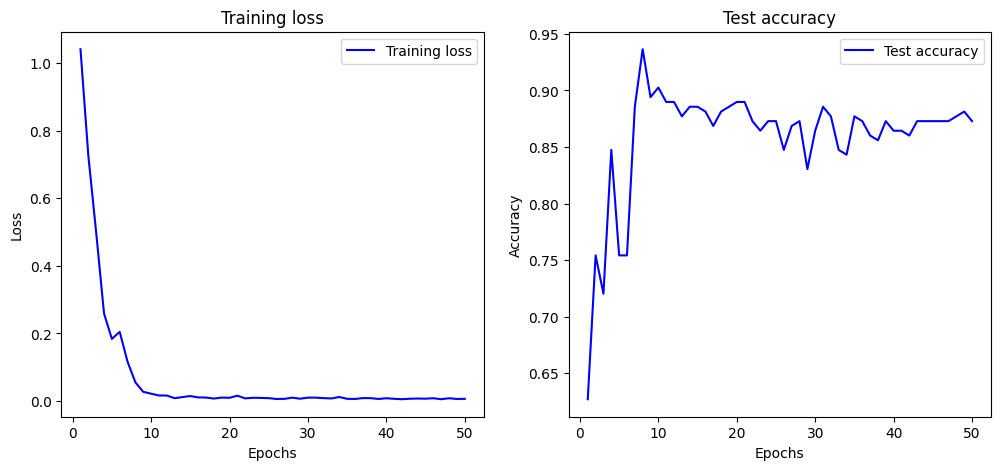

<Figure size 1000x900 with 0 Axes>

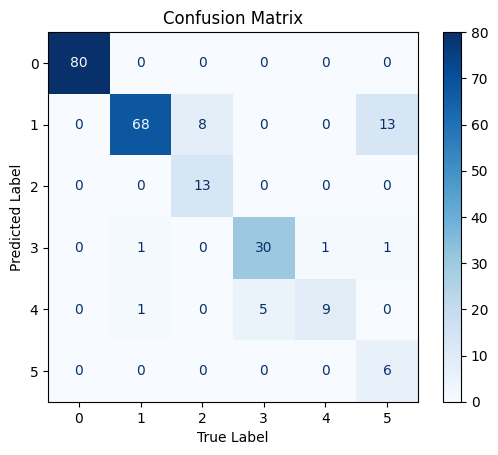

Class 0 accuracy: 1.0000
Class 1 accuracy: 0.7865
Class 2 accuracy: 1.6154
Class 3 accuracy: 1.0606
Class 4 accuracy: 0.6667
Class 5 accuracy: 3.3333


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms
import os
from PIL import Image
import datetime
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import xml.etree.ElementTree as ET
import torchvision.models as models
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import KFold
# Load the pre-trained VGG16 model

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
class vgg16_base(nn.Module):
    def __init__(self):
        super(vgg16_, self).__init__()
        vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        self.features = vgg.features
        self.avgpool = vgg.avgpool
        set_parameter_requires_grad(self.features, True)
        self.classifier=nn.Sequential(
            nn.Linear(512*7*7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 6)
        )
    def forward(self, x):
        x = self.features(x) 
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
class vgg16_(nn.Module):
    def __init__(self, num_classes=6):
        super(vgg16_, self).__init__()
        # 原始VGG16特征提取
        vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        self.features = vgg.features
        self.avgpool = vgg.avgpool
        # set_parameter_requires_grad(self.features, True)
        self.num_classes = num_classes
        # 分类器
        self.classifier = nn.Sequential(
            nn.Linear(512*7*7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )
        self.feature_maps = None
        self.gradients = None

        self.features[-1].register_forward_hook(self.save_feature_maps)
        self.features[-1].register_full_backward_hook(self.save_gradients)
    def save_feature_maps(self, module, input, output):
        self.feature_maps = output
    def save_gradients(self, module, input, grad_output):
        self.gradients =grad_output[0]

    def forward(self, x, mask=None,annotation=None):
        features = self.features(x)
        x = self.avgpool(features)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        attention_loss = 0.0
        if mask is not None and torch.sum(mask) > 0:
            with torch.enable_grad():
                # 创建独热向量
                # Initialize attention loss
                attention_loss = 0.0
                one_hot = torch.zeros_like(x)
                one_hot.scatter_(1, annotation.view(-1, 1), 1.0)
                
                # Backpropagate to get gradients
                gradients = torch.autograd.grad(outputs=x, inputs=features, grad_outputs=one_hot, retain_graph=True, create_graph=True)[0]
                # Calculate heatmap
                pooled_gradients = torch.mean(gradients, dim=[2, 3], keepdim=True)
                heatmap = features * pooled_gradients
                heatmap = torch.sum(heatmap, dim=1, keepdim=True)
                heatmap = torch.relu(heatmap)
                
                # Apply ReLU to highlight positive contributions
                
                # Normalize heatmap to 0-1 range
                B, C, H, W = heatmap.size()
                heatmap_flat = heatmap.view(B, C, -1)
                heatmap_max, _ = torch.max(heatmap_flat, dim=2, keepdim=True)
                heatmap_min, _ = torch.min(heatmap_flat, dim=2, keepdim=True)
                heatmap_max = heatmap_max.unsqueeze(-1)
                heatmap_min = heatmap_min.unsqueeze(-1)
                
                # Avoid division by zero
                epsilon = 1e-7
                normalized_heatmap = (heatmap - heatmap_min) / (heatmap_max - heatmap_min + epsilon)
                
                # Resize mask to match heatmap size
                # if annotation==i:
                mask_resized = F.interpolate(mask, size=(H, W), mode='bilinear', align_corners=False)
                # else:
                #     mask_resized = torch.zeros_like(normalized_heatmap)
                # Calculate heatmap loss (MSE loss)
                attention_loss = F.mse_loss(normalized_heatmap, mask_resized)
        return x, attention_loss
class tablet_dataset(Dataset):
    def __init__(self, image_dir, annotation_dir, image_transform=None):
        super().__init__()
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.image_filenames = [f for f in os.listdir(image_dir) if f.endswith('.bmp') and not f.endswith('_t.bmp')]
        self.image_transform = image_transform
    def __len__(self):
        return len(self.image_filenames)
    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        annotation = 0
        mask_name = os.path.splitext(img_name)[0] + '_t.bmp'
        mask_path = os.path.join(self.annotation_dir, mask_name)
        xml_filename = os.path.splitext(img_name)[0] + '.xml'
        xml_path = os.path.join(self.annotation_dir, xml_filename)
        if os.path.exists(xml_path):
            tree = ET.parse(xml_path)
            root = tree.getroot()
            annotation = int(root.find(".//flags").text)
            if annotation==6:
                annotation=1
            elif annotation==7:
                annotation=6
            elif annotation==8:
                annotation=4
            if annotation>1:
                annotation-=1
        mask = None
        if os.path.exists(mask_path) and annotation!=0:
            mask = Image.open(mask_path).convert('L')
            mask = mask.resize((160, 160))
            mask = transforms.ToTensor()(mask)
        else:
            mask = torch.zeros((1, 160, 160))
        if self.image_transform:
            image = self.image_transform(image)
        return image, annotation, mask
# Define the image transformations
image_transform = transforms.Compose([
    transforms.Resize((160,160)),
    # transforms.ColorJitter(contrast=2.0),  # Increase contrast
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



# Modify the VGG16 model for binary classification
vgg16 = vgg16_().to('cuda')
# Apply Xavier initialization to the classifier layers
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

vgg16.classifier.apply(initialize_weights)
# vgg16.load_state_dict(torch.load('vgg16_mask_very_good.pth'))
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.parameters(), lr=0.0001)

# Initialize lists to store loss and accuracy
train_losses = []
test_accuracies = []

# Function to plot loss and accuracy
def plot_metrics(train_losses, test_accuracies):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.title('Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot test accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, test_accuracies, 'b', label='Test accuracy')
    plt.title('Test accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
# Training loop
if __name__ == '__main__':
    # Create the dataset
    full_dataset = tablet_dataset(image_dir='20241108 with rgb', annotation_dir='20241108 with rgb', image_transform=image_transform)
    test_dataset = tablet_dataset(image_dir='train', annotation_dir='train', image_transform=image_transform)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=8)
    
    # Import KFold
    
    # K-fold Cross Validation parameters
    k_folds = 5
    num_epochs = 50
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    
    # Store results across folds
    fold_val_accuracies = []
    
    print(f"Starting {k_folds}-fold cross-validation")
    
    # K-fold Cross Validation
    for fold, (train_ids, val_ids) in enumerate(kfold.split(full_dataset)):
        print(f'FOLD {fold+1}/{k_folds}')
        print('-' * 50)
        
        # Reset model and optimizer for each fold
        vgg16 = vgg16_().to('cuda')
        vgg16.classifier.apply(initialize_weights)
        optimizer = optim.Adam(vgg16.parameters(), lr=0.0001)
        
        # Create data samplers and loaders for this fold
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
        
        train_loader = DataLoader(full_dataset, batch_size=32, sampler=train_subsampler, num_workers=8)
        val_loader = DataLoader(full_dataset, batch_size=32, sampler=val_subsampler, num_workers=8)
        
        # Training and validation for this fold
        fold_train_losses = []
        fold_val_accuracies = []
        best_val_accuracy = 0.0
        
        for epoch in range(num_epochs):
            # Training phase
            vgg16.train()
            running_loss = 0.0
            
            if epoch == 20:
                optimizer = optim.Adam(vgg16.parameters(), lr=0.00001)
                
            for images, labels, masks in train_loader:
                images = images.to('cuda')
                labels = labels.to('cuda')
                masks = masks.to('cuda')
                
                optimizer.zero_grad()
                outputs, attention_loss = vgg16(images, masks, labels)
                loss = criterion(outputs, labels)
                loss.backward(retain_graph=True)
                attention_loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
            
            epoch_loss = running_loss / len(train_loader)
            fold_train_losses.append(epoch_loss)
            
            # Validation phase
            vgg16.eval()
            correct = 0
            total = 0
            
            with torch.no_grad():
                for images, labels, _ in val_loader:
                    images = images.to('cuda')
                    labels = labels.to('cuda')
                    outputs, _ = vgg16(images)
                    predicted = torch.argmax(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            
            val_accuracy = correct / total
            fold_val_accuracies.append(val_accuracy)
            
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
            
            # Save best model for this fold
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                torch.save(vgg16.state_dict(), f'vgg16_fold{fold+1}_best.pth')
            
            if val_accuracy > 0.92:
                optimizer = optim.Adam(vgg16.parameters(), lr=0.00001)
        
        print(f'Fold {fold+1} best validation accuracy: {best_val_accuracy:.4f}')
        fold_val_accuracies.append(best_val_accuracy)
    
    # Print average validation accuracy across folds
    avg_val_accuracy = sum(fold_val_accuracies) / len(fold_val_accuracies)
    print(f'Average best validation accuracy across {k_folds} folds: {avg_val_accuracy:.4f}')
    
    # Train final model on entire dataset
    print('\nTraining final model on entire dataset...')
    full_loader = DataLoader(full_dataset, batch_size=32, shuffle=True, num_workers=8)
    
    # Reset model for final training
    vgg16 = vgg16_().to('cuda')
    vgg16.classifier.apply(initialize_weights)
    optimizer = optim.Adam(vgg16.parameters(), lr=0.0001)
    
    train_losses = []
    test_accuracies = []
    
    for epoch in range(num_epochs):
        vgg16.train()
        running_loss = 0.0
        
        if epoch == 20:
            optimizer = optim.Adam(vgg16.parameters(), lr=0.00001)
            
        for images, labels, masks in full_loader:
            images = images.to('cuda')
            labels = labels.to('cuda')
            masks = masks.to('cuda')
            
            optimizer.zero_grad()
            outputs, attention_loss = vgg16(images, masks, labels)
            loss = criterion(outputs, labels)
            loss.backward(retain_graph=True)
            attention_loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(full_loader)
        train_losses.append(epoch_loss)
        
        # Evaluate on test set
        vgg16.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels, _ in test_loader:
                images = images.to('cuda')
                labels = labels.to('cuda')
                outputs, _ = vgg16(images)
                predicted = torch.argmax(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        accuracy = correct / total
        test_accuracies.append(accuracy)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Test Accuracy: {accuracy:.4f}')
        
        if accuracy > 0.92:
            optimizer = optim.Adam(vgg16.parameters(), lr=0.00001)
    
    # Plot metrics for the final model
    plot_metrics(train_losses, test_accuracies)
    
    # Final evaluation on test set
    vgg16.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels, _ in test_loader:
            images = images.to('cuda')
            labels = labels.to('cuda')
            
            outputs, _ = vgg16(images)
            _, predictions = torch.max(outputs, 1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    
    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_predictions).T
    num_classes = len(np.unique(np.concatenate([all_labels, all_predictions])))

    # Display the confusion matrix
    plt.figure(figsize=(10, 9))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                 display_labels=list(range(num_classes)))
    disp.plot(cmap=plt.cm.Blues)
    plt.xlabel('True Label')
    plt.ylabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix_mask4.png')
    plt.show()
    # Calculate per-class accuracy (adjusted for transposed matrix)
    per_class_accuracy = cm.sum(axis=0) / cm.sum(axis=1)
    for i, accuracy in enumerate(per_class_accuracy):
        print(f'Class {i} accuracy: {accuracy:.4f}')
    # Save the model
    torch.save(vgg16.state_dict(), 'vgg16_mask_trained_model1.pth')

Starting 5-fold cross-validation
FOLD 1/5
--------------------------------------------------
Epoch [1/50], Loss: 2.9653, Validation Accuracy: 0.7234
Epoch [2/50], Loss: 1.0178, Validation Accuracy: 0.7660
Epoch [3/50], Loss: 0.5638, Validation Accuracy: 0.8617
Epoch [4/50], Loss: 0.3316, Validation Accuracy: 0.8830
Epoch [5/50], Loss: 0.2837, Validation Accuracy: 0.8936
Epoch [6/50], Loss: 0.1678, Validation Accuracy: 0.8936
Epoch [7/50], Loss: 0.0801, Validation Accuracy: 0.9149
Epoch [8/50], Loss: 0.1380, Validation Accuracy: 0.9149
Epoch [9/50], Loss: 0.0744, Validation Accuracy: 0.9149
Epoch [10/50], Loss: 0.3132, Validation Accuracy: 0.9043
Epoch [11/50], Loss: 0.1352, Validation Accuracy: 0.8830
Epoch [12/50], Loss: 0.1366, Validation Accuracy: 0.8936
Epoch [13/50], Loss: 0.3974, Validation Accuracy: 0.7766
Epoch [14/50], Loss: 0.3910, Validation Accuracy: 0.9043
Epoch [15/50], Loss: 0.3020, Validation Accuracy: 0.8936
Epoch [16/50], Loss: 0.2742, Validation Accuracy: 0.9149
Epoc

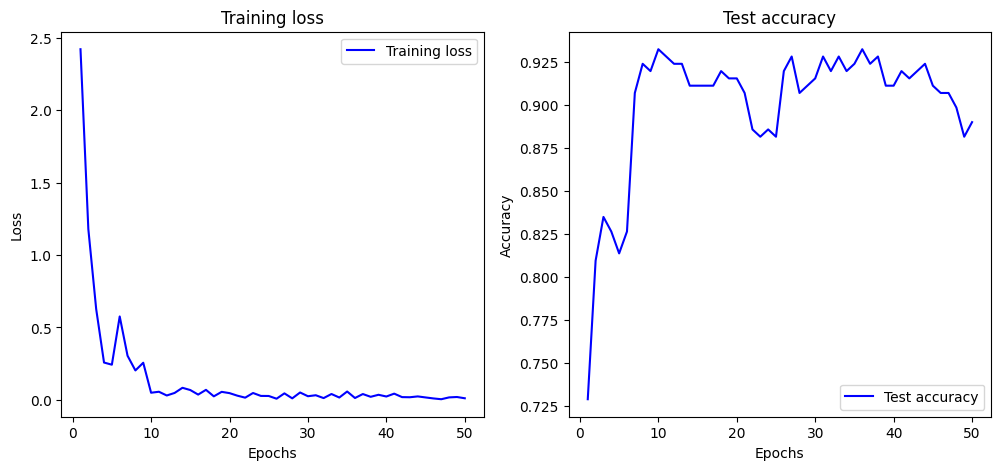

<Figure size 1000x900 with 0 Axes>

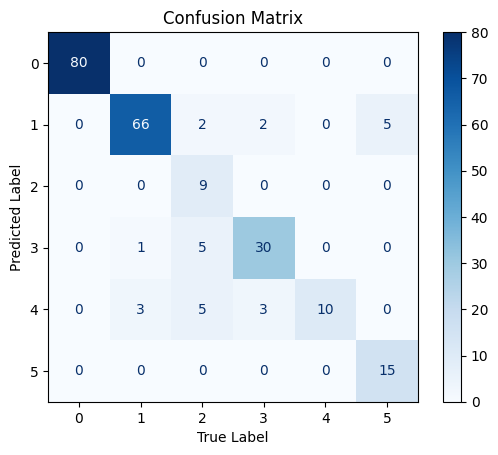

Class 0 accuracy: 1.0000
Class 1 accuracy: 0.9333
Class 2 accuracy: 2.3333
Class 3 accuracy: 0.9722
Class 4 accuracy: 0.4762
Class 5 accuracy: 1.3333


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms
import os
from PIL import Image
import datetime
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import xml.etree.ElementTree as ET
import torchvision.models as models
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import KFold
# DenseNet is already imported via torchvision.models

# Load the pre-trained VGG16 model

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

class densenet_(nn.Module):
    def __init__(self, num_classes=6, densenet_type='densenet121'):
        super(densenet_, self).__init__()
        
        # 选择DenseNet类型
        if densenet_type == 'densenet121':
            densenet = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
            feature_dim = 1024
        elif densenet_type == 'densenet169':
            densenet = models.densenet169(weights=models.DenseNet169_Weights.IMAGENET1K_V1)
            feature_dim = 1664
        elif densenet_type == 'densenet201':
            densenet = models.densenet201(weights=models.DenseNet201_Weights.IMAGENET1K_V1)
            feature_dim = 1920
        else:
            raise ValueError(f"不支持的DenseNet类型: {densenet_type}")
    
        # 取DenseNet的特征提取部分
        self.features = densenet.features
        self.num_classes = num_classes
        
        # 适应性平均池化，保持与VGG兼容
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        
        # 分类器
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )
        
        # 保存特征图和梯度的变量
        self.feature_maps = None
        self.gradients = None
        
        # 注册钩子
        self.features.norm5.register_forward_hook(self.save_feature_maps)
        self.features.norm5.register_full_backward_hook(self.save_gradients)
    
    def save_feature_maps(self, module, input, output):
        self.feature_maps = output
    
    def save_gradients(self, module, input, grad_output):
        self.gradients = grad_output[0]
    
    def forward(self, x, mask=None, annotation=None):
        features = self.features(x)
        x = self.avgpool(features)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        
        attention_loss = 0.0
        if mask is not None and torch.sum(mask) > 0:
            with torch.enable_grad():
                # 创建独热向量
                attention_loss = 0.0
                one_hot = torch.zeros_like(x)
                one_hot.scatter_(1, annotation.view(-1, 1), 1.0)
                
                # 反向传播获取梯度
                gradients = torch.autograd.grad(outputs=x, inputs=features, 
                                              grad_outputs=one_hot, 
                                              retain_graph=True, 
                                              create_graph=True)[0]
                
                # 计算热图
                pooled_gradients = torch.mean(gradients, dim=[2, 3], keepdim=True)
                heatmap = features * pooled_gradients
                heatmap = torch.sum(heatmap, dim=1, keepdim=True)
                heatmap = torch.relu(heatmap)
                
                # 归一化热图到0-1范围
                B, C, H, W = heatmap.size()
                heatmap_flat = heatmap.view(B, C, -1)
                heatmap_max, _ = torch.max(heatmap_flat, dim=2, keepdim=True)
                heatmap_min, _ = torch.min(heatmap_flat, dim=2, keepdim=True)
                heatmap_max = heatmap_max.unsqueeze(-1)
                heatmap_min = heatmap_min.unsqueeze(-1)
                
                # 避免除以零
                epsilon = 1e-7
                normalized_heatmap = (heatmap - heatmap_min) / (heatmap_max - heatmap_min + epsilon)
                
                # 调整掩码大小以匹配热图尺寸
                mask_resized = F.interpolate(mask, size=(H, W), mode='bilinear', align_corners=False)
                
                # 计算热图损失(MSE损失)
                attention_loss = F.mse_loss(normalized_heatmap, mask_resized)
                
        return x, attention_loss
class tablet_dataset(Dataset):
    def __init__(self, image_dir, annotation_dir, image_transform=None):
        super().__init__()
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.image_filenames = [f for f in os.listdir(image_dir) if f.endswith('.bmp') and not f.endswith('_t.bmp')]
        self.image_transform = image_transform
    def __len__(self):
        return len(self.image_filenames)
    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        annotation = 0
        mask_name = os.path.splitext(img_name)[0] + '_t.bmp'
        mask_path = os.path.join(self.annotation_dir, mask_name)
        xml_filename = os.path.splitext(img_name)[0] + '.xml'
        xml_path = os.path.join(self.annotation_dir, xml_filename)
        if os.path.exists(xml_path):
            tree = ET.parse(xml_path)
            root = tree.getroot()
            annotation = int(root.find(".//flags").text)
            if annotation==6:
                annotation=1
            elif annotation==7:
                annotation=6
            elif annotation==8:
                annotation=4
            if annotation>1:
                annotation-=1
        mask = None
        if os.path.exists(mask_path) and annotation!=0:
            mask = Image.open(mask_path).convert('L')
            mask = mask.resize((160, 160))
            mask = transforms.ToTensor()(mask)
        else:
            mask = torch.zeros((1, 160, 160))
        if self.image_transform:
            image = self.image_transform(image)
        return image, annotation, mask
# Define the image transformations
image_transform = transforms.Compose([
    transforms.Resize((160,160)),
    # transforms.ColorJitter(contrast=2.0),  # Increase contrast
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



# Modify the DenseNet model for binary classification
densenet = densenet_().to('cuda')
# Apply Xavier initialization to the classifier layers
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

densenet.classifier.apply(initialize_weights)
# densenet.load_state_dict(torch.load('vgg16_mask_very_good.pth'))
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(densenet.parameters(), lr=0.0001)

# Initialize lists to store loss and accuracy
train_losses = []
test_accuracies = []

# Function to plot loss and accuracy
def plot_metrics(train_losses, test_accuracies):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.title('Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot test accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, test_accuracies, 'b', label='Test accuracy')
    plt.title('Test accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
# Training loop
if __name__ == '__main__':
    # Create the dataset
    full_dataset = tablet_dataset(image_dir='20241108 with rgb', annotation_dir='20241108 with rgb', image_transform=image_transform)
    test_dataset = tablet_dataset(image_dir='train', annotation_dir='train', image_transform=image_transform)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=16)
    
    # Import KFold
    
    # K-fold Cross Validation parameters
    k_folds = 5
    num_epochs = 50
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    
    # Store results across folds
    fold_val_accuracies = []
    
    print(f"Starting {k_folds}-fold cross-validation")
    
    # K-fold Cross Validation
    for fold, (train_ids, val_ids) in enumerate(kfold.split(full_dataset)):
        print(f'FOLD {fold+1}/{k_folds}')
        print('-' * 50)
        
        # Reset model and optimizer for each fold
        densenet = densenet_().to('cuda')
        densenet.classifier.apply(initialize_weights)
        optimizer = optim.Adam(densenet.parameters(), lr=0.0001)
        
        # Create data samplers and loaders for this fold
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
        
        train_loader = DataLoader(full_dataset, batch_size=32, sampler=train_subsampler, num_workers=16)
        val_loader = DataLoader(full_dataset, batch_size=32, sampler=val_subsampler, num_workers=16)
        
        # Training and validation for this fold
        fold_train_losses = []
        fold_val_accuracies = []
        best_val_accuracy = 0.0
        
        for epoch in range(num_epochs):
            # Training phase
            densenet.train()
            running_loss = 0.0
            
            if epoch == 20:
                optimizer = optim.Adam(densenet.parameters(), lr=0.00001)
                
            for images, labels, masks in train_loader:
                images = images.to('cuda')
                labels = labels.to('cuda')
                masks = masks.to('cuda')
                
                optimizer.zero_grad()
                outputs, attention_loss = densenet(images, masks, labels)
                loss = criterion(outputs, labels)
                loss.backward(retain_graph=True)
                attention_loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
            
            epoch_loss = running_loss / len(train_loader)
            fold_train_losses.append(epoch_loss)
            
            # Validation phase
            densenet.eval()
            correct = 0
            total = 0
            
            with torch.no_grad():
                for images, labels, _ in val_loader:
                    images = images.to('cuda')
                    labels = labels.to('cuda')
                    outputs, _ = densenet(images)
                    predicted = torch.argmax(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            
            val_accuracy = correct / total
            fold_val_accuracies.append(val_accuracy)
            
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
            
            # Save best model for this fold
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                torch.save(densenet.state_dict(), f'densenet_fold{fold+1}_best.pth')
            
            if val_accuracy > 0.92:
                optimizer = optim.Adam(densenet.parameters(), lr=0.00001)
        
        print(f'Fold {fold+1} best validation accuracy: {best_val_accuracy:.4f}')
        fold_val_accuracies.append(best_val_accuracy)
    
    # Print average validation accuracy across folds
    avg_val_accuracy = sum(fold_val_accuracies) / len(fold_val_accuracies)
    print(f'Average best validation accuracy across {k_folds} folds: {avg_val_accuracy:.4f}')
    
    # Train final model on entire dataset
    print('\nTraining final model on entire dataset...')
    full_loader = DataLoader(full_dataset, batch_size=32, shuffle=True, num_workers=16)
    
    # Reset model for final training
    densenet = densenet_().to('cuda')
    densenet.classifier.apply(initialize_weights)
    optimizer = optim.Adam(densenet.parameters(), lr=0.0001)
    
    train_losses = []
    test_accuracies = []
    
    for epoch in range(num_epochs):
        densenet.train()
        running_loss = 0.0
        
        if epoch == 20:
            optimizer = optim.Adam(densenet.parameters(), lr=0.00001)
            
        for images, labels, masks in full_loader:
            images = images.to('cuda')
            labels = labels.to('cuda')
            masks = masks.to('cuda')
            
            optimizer.zero_grad()
            outputs, attention_loss = densenet(images, masks, labels)
            loss = criterion(outputs, labels)
            loss.backward(retain_graph=True)
            attention_loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(full_loader)
        train_losses.append(epoch_loss)
        
        # Evaluate on test set
        densenet.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels, _ in test_loader:
                images = images.to('cuda')
                labels = labels.to('cuda')
                outputs, _ = densenet(images)
                predicted = torch.argmax(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        accuracy = correct / total
        test_accuracies.append(accuracy)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Test Accuracy: {accuracy:.4f}')
        
        if accuracy > 0.92:
            optimizer = optim.Adam(densenet.parameters(), lr=0.00001)
    
    # Plot metrics for the final model
    plot_metrics(train_losses, test_accuracies)
    
    # Final evaluation on test set
    densenet.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels, _ in test_loader:
            images = images.to('cuda')
            labels = labels.to('cuda')
            
            outputs, _ = densenet(images)
            _, predictions = torch.max(outputs, 1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    
    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_predictions).T
    num_classes = len(np.unique(np.concatenate([all_labels, all_predictions])))

    # Display the confusion matrix
    plt.figure(figsize=(10, 9))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                 display_labels=list(range(num_classes)))
    disp.plot(cmap=plt.cm.Blues)
    plt.xlabel('True Label')
    plt.ylabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix_mask4.png')
    plt.show()
    # Calculate per-class accuracy (adjusted for transposed matrix)
    per_class_accuracy = cm.sum(axis=0) / cm.sum(axis=1)
    for i, accuracy in enumerate(per_class_accuracy):
        print(f'Class {i} accuracy: {accuracy:.4f}')
    # Save the model
    torch.save(densenet.state_dict(), 'densenet_mask_trained_model_final.pth')